In [96]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import glob
import itertools
import pickle
from enum import Enum
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.model_selection import train_test_split

from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from collections import OrderedDict, defaultdict

import networks
import data_loader

In [105]:
data_root = "../Project/6_train/images/"
models = ['dual_gans_un', 'dual_gans_semi', 'cycle_gan_un', 'cycle_gan_semi', 'semantic']
model_dict = defaultdict.fromkeys(models)
model_dict_recon = defaultdict.fromkeys(models)
image_size = 256
batch_size = 2
ngpu = torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [106]:
for i in range(len(models)):
    path = 'saved_models/test_' + models[i] + '_generator_b.pth'
    model_dict[models[i]] = path
    print("{} - {}".format(models[i], path))
    
for i in range(len(models) - 1):
    path = 'saved_models/test_' + models[i] + '_generator_a.pth'
    model_dict_recon[models[i]] = path
    print("{} - {}".format(models[i], path))

dual_gans_un - saved_models/test_dual_gans_un_generator_b.pth
dual_gans_semi - saved_models/test_dual_gans_semi_generator_b.pth
cycle_gan_un - saved_models/test_cycle_gan_un_generator_b.pth
cycle_gan_semi - saved_models/test_cycle_gan_semi_generator_b.pth
semantic - saved_models/test_semantic_generator_b.pth
dual_gans_un - saved_models/test_dual_gans_un_generator_a.pth
dual_gans_semi - saved_models/test_dual_gans_semi_generator_a.pth
cycle_gan_un - saved_models/test_cycle_gan_un_generator_a.pth
cycle_gan_semi - saved_models/test_cycle_gan_semi_generator_a.pth


In [107]:
def normalize(image):
    return (image - torch.min(image))/(torch.max(image) - torch.min(image))

In [114]:
def display_image(gta, cityscapes, gta_recon, semantic_sample):
    for j in range(1):
        image_output = torch.cat((gta[j,:,:,:].data, cityscapes[j,:,:,:].data, gta_recon[j,:,:,:].data, semantic_sample[j,:,:,:].data), -1).detach().cpu().numpy()
        image = np.moveaxis(image_output, 0, -1)
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        plt.show()

In [122]:
def test_model():    
    # Load the data
    data = data_loader.DataLoader(data_root, image_size, batch_size)
    
    # Load the GTA to Cityscapes generator model for Dual Gans trained without any supervision 
    dual_gans_unsupervised = networks.DualGansGenerator().to(device)
    dual_gans_unsupervised.load_state_dict(torch.load(model_dict[models[0]]))
    # Load the Cityscapes to GTA generator model for Dual Gans trained without any supervision 
    dual_gans_unsupervised_recon = networks.DualGansGenerator().to(device)
    dual_gans_unsupervised_recon.load_state_dict(torch.load(model_dict_recon[models[0]]))
    
    # Load the GTA to Cityscapes generator model for Dual Gans trained with 25% of labelled supervision 
    dual_gans_semisupervised = networks.DualGansGenerator().to(device)
    dual_gans_semisupervised.load_state_dict(torch.load(model_dict[models[1]]))
    # Load the Cityscapes to GTA generator model for Dual Gans trained with 25% of labelled supervision 
    dual_gans_semisupervised_recon = networks.DualGansGenerator().to(device)
    dual_gans_semisupervised_recon.load_state_dict(torch.load(model_dict_recon[models[1]]))
    
    # Load the GTA to Cityscapes generator model for Cycle Gan trained without any supervision 
    cycle_gan_unsupervised = networks.CycleGanResnetGenerator().to(device)
    cycle_gan_unsupervised.load_state_dict(torch.load(model_dict[models[2]]))
    # Load the Cityscapes to GTA generator model for Cycle Gan trained without any supervision 
    cycle_gan_unsupervised_recon = networks.CycleGanResnetGenerator().to(device)
    cycle_gan_unsupervised_recon.load_state_dict(torch.load(model_dict_recon[models[2]]))
    
    # Load the GTA to Cityscapes generator model for Cycle Gan trained with 25% of labelled supervision    
    cycle_gan_semisupervised = networks.CycleGanResnetGenerator().to(device)
    cycle_gan_semisupervised.load_state_dict(torch.load(model_dict[models[3]]))
    # Load the Cityscapes to GTA generator model for Cycle Gan trained with 25% of labelled supervision
    cycle_gan_semisupervised_recon = networks.CycleGanResnetGenerator().to(device)
    cycle_gan_semisupervised_recon.load_state_dict(torch.load(model_dict_recon[models[3]]))
   
    # Load the Semantic Segmentation generator used for reporing F1 score results
    semantic_model = networks.GeneratorUNet().to(device)
    semantic_model.load_state_dict(torch.load(model_dict[models[-1]]))
    
    print('All Models loaded... \n')
    
    x, y = next(data.data_generator(0, train = False))

    gta_im = Variable(y, requires_grad = False).to(device)
    gta_im = normalize(gta_im)
    
    print('Dual Gans Unsupervised - Original GTA image, Adapted Cityscapes image, Reconstructed GTA image, Segmented image')
    cityscapes_dual_gans_un = dual_gans_unsupervised(gta_im)
    cityscapes_dual_gans_un = normalize(cityscapes_dual_gans_un)
    gta_dual_gans_un = dual_gans_unsupervised_recon(cityscapes_dual_gans_un)
    gta_dual_gans_un = normalize(gta_dual_gans_un)
    semantic_dual_gans_un = semantic_model(cityscapes_dual_gans_un)
    semantic_dual_gans_un = normalize(semantic_dual_gans_un)
    display_image(gta_im, cityscapes_dual_gans_un, gta_dual_gans_un, semantic_dual_gans_un)

    print('Dual Gans Semisuervised - Original GTA image, Adapted Cityscapes image, Reconstructed GTA image, Segmented image')
    cityscapes_dual_gans_semi = dual_gans_semisupervised(gta_im)
    cityscapes_dual_gans_semi = normalize(cityscapes_dual_gans_semi)
    gta_dual_gans_semi = dual_gans_semisupervised_recon(cityscapes_dual_gans_semi)
    gta_dual_gans_semi = normalize(gta_dual_gans_semi)
    semantic_dual_gans_semi = semantic_model(cityscapes_dual_gans_semi)
    semantic_dual_gans_semi = normalize(semantic_dual_gans_semi)
    display_image(gta_im, cityscapes_dual_gans_semi, gta_dual_gans_semi, semantic_dual_gans_semi)
    
    print('Cycle Gan Unsupervised - Original GTA image, Adapted Cityscapes image, Reconstructed GTA image, Segmented image')
    cityscapes_cycle_gan_un = cycle_gan_unsupervised(gta_im)
    cityscapes_cycle_gan_un = normalize(cityscapes_cycle_gan_un)
    gta_cycle_gan_un = cycle_gan_unsupervised_recon(cityscapes_cycle_gan_un)
    gta_cycle_gan_un = normalize(gta_cycle_gan_un)
    semantic_cycle_gan_un = semantic_model(cityscapes_cycle_gan_un)
    semantic_cycle_gan_un = normalize(semantic_cycle_gan_un)
    display_image(gta_im, cityscapes_cycle_gan_un, gta_cycle_gan_un, semantic_cycle_gan_un)
    
    print('Cycle Gan Semisuervised - Original GTA image, Adapted Cityscapes image, Reconstructed GTA image, Segmented image')
    cityscapes_cycle_gan_semi = cycle_gan_semisupervised(gta_im)
    cityscapes_cycle_gan_semi = normalize(cityscapes_cycle_gan_semi)
    gta_cycle_gan_semi = cycle_gan_semisupervised_recon(cityscapes_cycle_gan_semi)
    gta_cycle_gan_semi = normalize(gta_cycle_gan_semi)
    semantic_cycle_gan_semi = semantic_model(cityscapes_cycle_gan_semi)
    semantic_cycle_gan_semi = normalize(semantic_cycle_gan_semi)
    display_image(gta_im, cityscapes_cycle_gan_semi, gta_cycle_gan_semi, semantic_cycle_gan_semi)

All Models loaded... 

Dual Gans Unsupervised - Original GTA image, Adapted Cityscapes image, Reconstructed GTA image, Segmented image


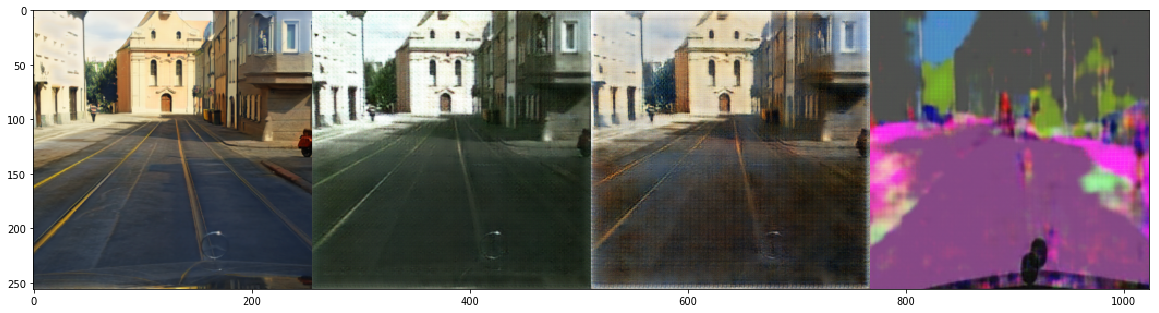

Dual Gans Semisuervised - Original GTA image, Adapted Cityscapes image, Reconstructed GTA image, Segmented image


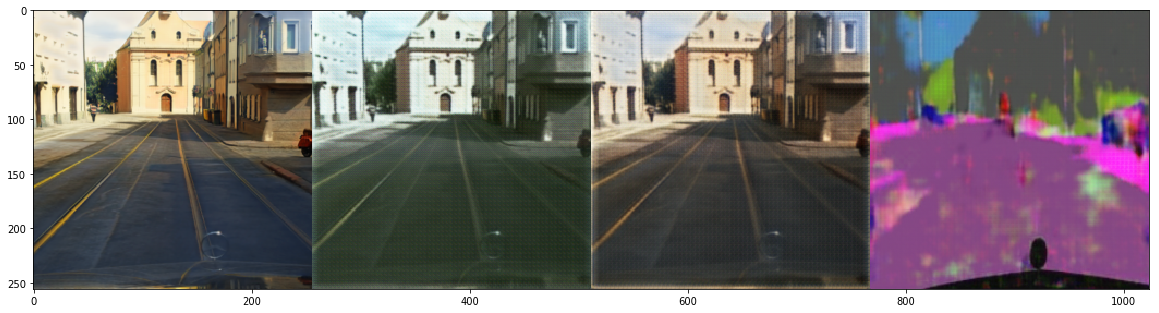

Cycle Gan Unsupervised - Original GTA image, Adapted Cityscapes image, Reconstructed GTA image, Segmented image


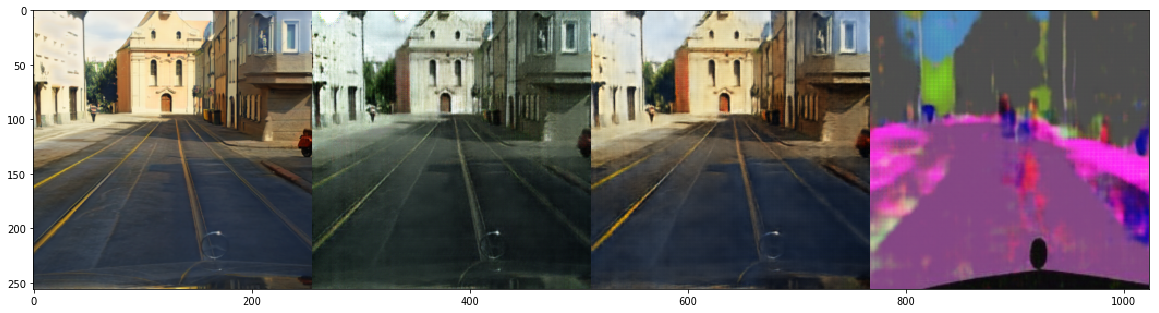

Cycle Gan Semisuervised - Original GTA image, Adapted Cityscapes image, Reconstructed GTA image, Segmented image


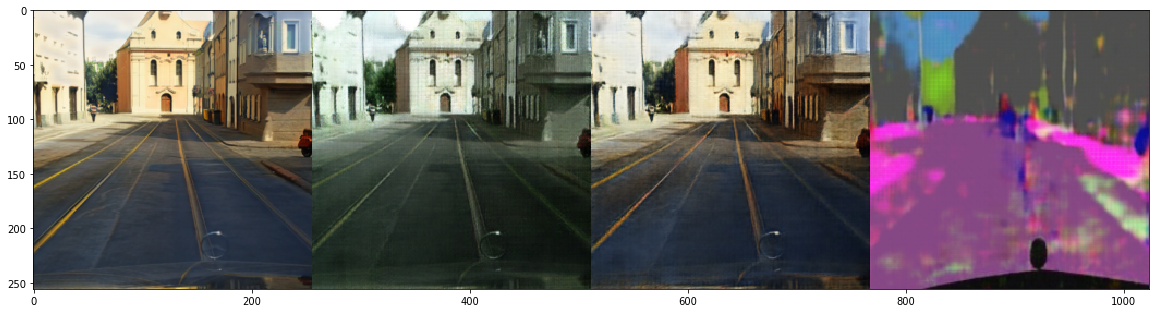

In [124]:
test_model()